# Experiments with Memory Access and Matrices

In many problems, especially problems accessing lots of data and doing relatively simple computations on each datum, the performance bottleneck is memory rather than computational speed.  Because memory is arranged into a **memory hierarchy** of larger/slower and smaller/faster memories, it turns out that *changing the order* of memory access can have a huge impact on performance.

In this notebook, we'll explore these performance issues with a few typical matrix algorithms, implemented in Julia.

In [27]:
using BenchmarkTools # a useful package of benchmarking utilities
versioninfo() # a useful function to print out information about the machine

Julia Version 0.6.3
Commit d55cadc350 (2018-05-28 20:20 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin14.5.0)
  CPU: Intel(R) Core(TM) i7-6820HQ CPU @ 2.70GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.9.1 (ORCJIT, skylake)


## Benchmarking Matrix Multiplication

One of the most basic building blocks of numerical linear algebra is the computation of matrix multiplication: given an $m \times n$ matrix $A$ and an $n \times p$ matrix $B$, compute the $m \times p$ matrix $C = AB$.   The entries of $C$ are given by the exact formula:
$$
C_{ik} = \sum_{j=1}^n A_{ij} B_{jk}
$$
but there are many ways to implement this computation.   $\approx 2mnp$ flops (floating-point additions and multiplications) are required, but they can re-ordered arbitrarily, leading to $\sim (mnp)!$ possible orderings.

It turns out that the ordering of the operations in the matrix multiplication has a *huge* impact on performance, along with low-level details of the inner loops.  Basically, three factors make the implementation of efficient matrix multiplication highly nontrivial:

* [Caches](https://en.wikipedia.org/wiki/CPU_cache): the matrix accesses must be reordered to obtain [temporal locality](https://en.wikipedia.org/wiki/Locality_of_reference) and hence efficient memory (cache) usage.
* [Registers](https://en.wikipedia.org/wiki/Processor_register): at the lowest level, the CPU registers form a kind of ideal cache.  The innermost loops of the matrix multiplication need to be unrolled in order to load many values into registers and perform as much work with them as possible (essentially a small submatrix multiplication).  It turns out that a [lot of tricks](http://cscads.rice.edu/workshops/july2007/autotune-slides-07/Frigo.pdf) are required to do this well.
* [SIMD instructions](https://en.wikipedia.org/wiki/SIMD): modern CPUs include special instructions that can perform several arithmetic operations at once (e.g. 2, 4, or even 8 `Float64` operations), and to get the full benefit of these operations typically requires hand coding. 

As a consequence, there is a huge performance gap between the most obvious three-loop matrix-multiplication code and highly optimized code.  This gap has become the central factor in the design of dense linear-algebra libraries for several decades, especially the industry-standard free/open-source the [LAPACK](https://en.wikipedia.org/wiki/LAPACK) library: nearly all dense linear algebra is now organized around highly optimized [BLAS](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms) libraries.

Because Julia benefits from fast compilers, we can illustrate this performance gap fairly with simple Julia code.  (In contrast, similar implementation in Matlab or Python would be orders of magnitude slower, and would demonstrate mostly language rather than the algorithmic effects.)

### Naive algorithm

The following is the simplest, most obvious, matrix-multiplication algorithm: just three nested loops, implementing a dot product for each output $C_{ik}$.

The only concessions we have made to performance concerns here are (1) we implement an in-place `matmul!` variant that operates on a pre-existing `C` array, to avoid benchmarking the memory allocation/deallocation and (2) we use the `@inbounds` macro to turn off array bounds-checking in Julia for the inner loop.   Together, these make less than a factor of two difference in speed.

In [2]:
# compute C = A * B, using naive matrix-multiplication algorithm,
# with a pre-allocated output array C.  ("!" is a Julia convention
# for functions that modify their arguments.)
function matmul!(C, A, B)
    m,n = size(A)
    n,p = size(B)
    size(C) == (m,p) || error("incorrect dimensions ", size(C), " ≠ $m × $p")
    for i = 1:m
        for k = 1:p
            c = zero(eltype(C))
            for j = 1:n
                @inbounds c += A[i,j] * B[j,k]
            end
            @inbounds C[i,k] = c
        end
    end
    return C
end

# a wrapper that allocates C of an appropriate type
matmul(A, B) = matmul!(Array{promote_type(eltype(A), eltype(B))}(
                             size(A,1), size(B,2)),
                       A, B)

matmul (generic function with 1 method)

In [3]:
# correctness check:
A = rand(5,6)
B = rand(6,7)
norm(matmul(A,B) - A * B)

4.634357216034927e-16

#### Benchmarking naive `matmul`

Here, we will benchmark our naive `matmul` implementation against the highly optimized [OpenBLAS library](http://www.openblas.net/) that Julia uses for its built-in matrix multiplication.   Like `matmul!`, we will call OpenBLAS with pre-allocated output via `A_mul_B!(C, A, B)` instead of the simpler `A * B`.  By default, OpenBLAS uses multiple CPU cores, which gives it an "unfair" parallel speedup, but we can disable this for benchmarking purposes:

In [4]:
# for benchmarking, use only single-threaded BLAS:
BLAS.set_num_threads(1)

We will benchmark $n \times n$ matrix multiplications for various $n$ from 10 to 1000.  Julia's `@elapsed ...code...` macro is useful for benchmarking: it times the code and returns the time in seconds.   As we go, we will print the ratio of the naive time to the optimized time, to see the slowdown of our naive code.

In [5]:
N = round.(Int, logspace(1, log10(3000), 60))  # 60 sizes from 10 to 3000
# alternatively, use N = 10:1000 to see some interesting patterns due to cache associativity etc.
t = Float64[]
t0 = Float64[]
for n in N
    A = zeros(n,n)
    B = zeros(n,n)
    # preallocate output C so that allocation is not included in timing
    C = zeros(n,n)
    push!(t, @elapsed matmul!(C,A,B))
    push!(t0, @elapsed A_mul_B!(C,A,B))
    println("finished n = $n: slowdown of ", t[end]/t0[end])
end

finished n = 10: slowdown of 0.003439432651965679
finished n = 11: slowdown of 0.2545180722891566
finished n = 12: slowdown of 0.873394495412844
finished n = 13: slowdown of 0.9436201780415431
finished n = 15: slowdown of 1.2254395036194417
finished n = 16: slowdown of 1.7104773713577186
finished n = 18: slowdown of 1.9799176107106071
finished n = 20: slowdown of 2.508458192363461
finished n = 22: slowdown of 2.62043795620438
finished n = 24: slowdown of 0.5429614993114185
finished n = 26: slowdown of 3.1448810478481692
finished n = 29: slowdown of 3.594606164383561
finished n = 32: slowdown of 5.246299977910316
finished n = 35: slowdown of 3.394547759932375
finished n = 39: slowdown of 5.196760362077179
finished n = 43: slowdown of 3.9040229119488474
finished n = 47: slowdown of 5.2670193034279045
finished n = 52: slowdown of 7.325154234436344
finished n = 57: slowdown of 7.124171499585749
finished n = 63: slowdown of 7.51951927730279
finished n = 69: slowdown of 7.154025331198136
fin

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] round(::Type{Int64}, ::Array{Float64,1}) at ./deprecated.jl:57
 [3] include_string(::String, ::String) at ./loading.jl:522
 [4] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/stevenj/.julia/v0.6/IJulia/src/execute_request.jl:193
 [5] (::Compat.#inner#14{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /Users/stevenj/.julia/v0.6/Compat/src/Compat.jl:332
 [6] eventloop(::ZMQ.Socket) at /Users/stevenj/.julia/v0.6/IJulia/src/eventloop.jl:8
 [7] (::IJulia.##13#16)() at ./task.jl:335
while loading In[5], in expression starting on line 1


finished n = 200: slowdown of 20.744656162817975
finished n = 221: slowdown of 20.409211484147644
finished n = 243: slowdown of 19.86331608581282
finished n = 268: slowdown of 19.133545394614316
finished n = 295: slowdown of 22.49223626607818
finished n = 325: slowdown of 17.95879783625162
finished n = 358: slowdown of 24.751094820215997
finished n = 394: slowdown of 27.12657766258112
finished n = 434: slowdown of 26.018988143044584
finished n = 478: slowdown of 25.700658917753287
finished n = 526: slowdown of 20.302710352017133
finished n = 580: slowdown of 28.772426389152816
finished n = 639: slowdown of 26.56611380542917
finished n = 704: slowdown of 30.649836279537535
finished n = 775: slowdown of 27.86497068494215
finished n = 854: slowdown of 29.046256303689397
finished n = 940: slowdown of 28.429680508365756
finished n = 1036: slowdown of 25.603745960821687
finished n = 1141: slowdown of 41.45394569890129
finished n = 1257: slowdown of 34.7506882703886
finished n = 1384: slowdow

In [6]:
using PyPlot # a plotting library based on Python's Matplotlib

Now, we will plot the results.  Since the number of flops is $2n^3$, we will plot $2n^3 / t$ for time $t$ in microseconds in order to plot the **gigaflops rate** (billions of flops per second).  If you naively think of a CPU as a box that performs floating-point instructions at a fixed rate, with all other instructions being negligible (a picture that *may* have been true circa 1985), this would be a flat horizontal line independent of $n$, but we will see that reality is quite different.

The OpenBLAS library gets an "unfair" factor of 8 speedup on typical modern Intel processors thanks to hand-coded support for [AVX-512](https://en.wikipedia.org/wiki/Advanced_Vector_Extensions) SIMD instructions, which perform 8 double-precision floating-point operations simultaneously, so we will divide the BLAS performance by 8 for comparison purposes.

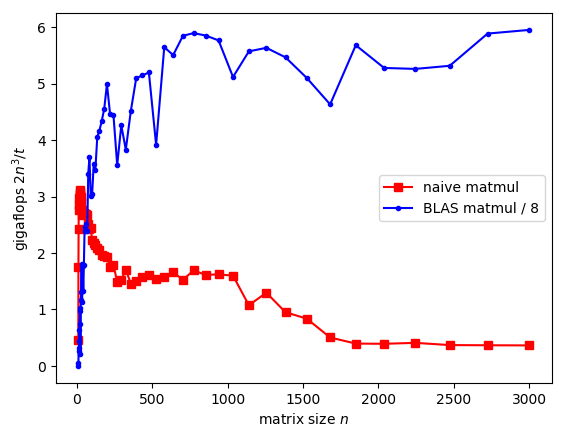

PyObject <matplotlib.legend.Legend object at 0x139e1dfd0>

In [7]:
plot(N, 2N.^3 ./ t * 1e-9, "rs-")
plot(N, 2N.^3 ./ t0 * 1e-9 / 8, "b.-")
ylabel(L"gigaflops $2n^3/t$")
xlabel(L"matrix size $n$")
legend(["naive matmul", "BLAS matmul / 8"], loc="center right")

#### Naive matmul in C

You may be suspicious that the problem is simply that Julia is slow.   We can check this hypothesis by implementing the same algorithm in C, compiling it, and then calling it by Julia's built-in `ccall` instruction that makes it [easy to call C from Julia](http://docs.julialang.org/en/latest/manual/calling-c-and-fortran-code/).

In [12]:
# C implementation:
Cmatmul = """
void Cmatmul(int m, int n, int p, double *C, double *A, double *B)
{
    int i, j, k;
    for (i = 0; i < m; ++i)
        for (j = 0; j < p; ++j) {
            double c = 0.0;
            for (k = 0; k < n; ++k)
                c += A[i + m*k] * B[k + n*j];
            C[i + m*j] = c;
    }
}
"""
# compile to a shared library by piping Cmatmul to gcc:
# (only works if you have gcc installed)
const Clib = tempname()
open(`gcc -fPIC -O3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, Cmatmul)
end

# define a Julia cmatmul! function that simply calls the C code in the shared library we compiled
function cmatmul!(C, A, B)
    m,n = size(A)
    n,p = size(B)
    size(C) == (m,p) || error("incorrect dimensions ", size(C), " ≠ $m × $p")
    ccall(("Cmatmul", Clib), Void, (Cint, Cint, Cint, Ptr{Float64}, Ptr{Float64}, Ptr{Float64}),
          m, n, p, C, A, B)
    return C
end
cmatmul(A, B) = cmatmul!(Array{promote_type(eltype(A), eltype(B))}(
                               size(A,1), size(B,2)),
                         A, B)

cmatmul (generic function with 1 method)

In [13]:
# correctness check:
A = rand(5,6)
B = rand(6,7)
norm(cmatmul(A,B) - A * B)

4.803007031519277e-16

Now, let's benchmark it and print out the "speedup" compared to pure Julia.  We see that it is **about the same speed**.  Julia's main claim to fame is that it is a dynamic language (like Python or Matlab) that stays within a factor of 2 (usually better) of C.

In [14]:
tc = Float64[]
for n in N[N .<= 1000]
    A = zeros(n,n)
    B = zeros(n,n)
    # preallocate output C so that allocation is not included in timing
    C = zeros(n,n)
    push!(tc, @elapsed cmatmul!(C,A,B))
    println("finished n = $n: speedup of ", tc[end]/t[length(tc)])
end

finished n = 10: speedup of 1.108195211786372
finished n = 11: speedup of 1.1926364234056541
finished n = 12: speedup of 1.3158263305322129
finished n = 13: speedup of 1.4289308176100628
finished n = 15: speedup of 1.2974683544303798
finished n = 16: speedup of 1.2631388184124683
finished n = 18: speedup of 1.24629388816645
finished n = 20: speedup of 1.184393063583815
finished n = 22: speedup of 1.211845770414895
finished n = 24: speedup of 1.179422143802382
finished n = 26: speedup of 1.1528261793455163
finished n = 29: speedup of 1.3317256162915327
finished n = 32: speedup of 1.2341473684210527
finished n = 35: speedup of 1.252817032932827
finished n = 39: speedup of 1.280848918225156
finished n = 43: speedup of 1.2828456879638317
finished n = 47: speedup of 1.2779502295492486
finished n = 52: speedup of 1.2538617613843002
finished n = 57: speedup of 1.2922184588100187
finished n = 63: speedup of 1.3378634944812127
finished n = 69: speedup of 1.3836918255631754
finished n = 76: spee

### Cache-oblivious matrix-multiplication

As a first step in the right direction, we'll implement a [cache-oblivious algorithm](https://en.wikipedia.org/wiki/Cache-oblivious_algorithm) for matrix multiplication: divide the matrices into four submatrices which are multiplied *recursively* until a sufficiently large base case is reached (large enough to amortize the recursion overhead).   This strategy erases the steep performance drop-off that occurs for large $n$ where the matrix goes out-of-cache, at the cost of ~25 lines of code rather than ~10 for the naive loops.

(It still doesn't match the OpenBLAS performance because it fails to address the other two problems: unrolling and optimizing the base cases to optimize register utilization, and coding for SIMD instructions.)

In [15]:
function add_matmul_rec!(m,n,p, i0,j0,k0, C,A,B)
    if m+n+p <= 64   # base case: naive matmult for sufficiently large matrices
        for i = 1:m
            for k = 1:p
                c = zero(eltype(C))
                for j = 1:n
                    @inbounds c += A[i0+i,j0+j] * B[j0+j,k0+k]
                end
                @inbounds C[i0+i,k0+k] += c
            end
        end
    else
        m2 = m ÷ 2; n2 = n ÷ 2; p2 = p ÷ 2
        add_matmul_rec!(m2, n2, p2, i0, j0, k0, C, A, B)
        
        add_matmul_rec!(m-m2, n2, p2, i0+m2, j0, k0, C, A, B)
        add_matmul_rec!(m2, n-n2, p2, i0, j0+n2, k0, C, A, B)
        add_matmul_rec!(m2, n2, p-p2, i0, j0, k0+p2, C, A, B)
        
        add_matmul_rec!(m-m2, n-n2, p2, i0+m2, j0+n2, k0, C, A, B)
        add_matmul_rec!(m2, n-n2, p-p2, i0, j0+n2, k0+p2, C, A, B)
        add_matmul_rec!(m-m2, n2, p-p2, i0+m2, j0, k0+p2, C, A, B)
        
        add_matmul_rec!(m-m2, n-n2, p-p2, i0+m2, j0+n2, k0+p2, C, A, B)
    end
    return C
end

function matmul_rec!(C, A, B)
    m,n = size(A)
    n,p = size(B)
    size(C) == (m,p) || error("incorrect dimensions ", size(C), " ≠ $m × $p")
    fill!(C, 0)
    return add_matmul_rec!(m,n,p, 0,0,0, C,A,B)
end


matmul_rec(A, B) = matmul_rec!(Array{promote_type(eltype(A), eltype(B))}(
                                     size(A,1), size(B,2)),
                               A, B)

matmul_rec (generic function with 1 method)

In [16]:
# correctness check:
A = rand(50,60)
B = rand(60,70)
norm(matmul_rec(A,B) - A * B)

5.02459954226118e-14

In [17]:
tco = Float64[]
for n in N
    A = zeros(n,n)
    B = zeros(n,n)
    # preallocate output C so that allocation is not included in timing
    C = zeros(n,n)
    push!(tco, @elapsed matmul_rec!(C,A,B))
    println("finished n = $n: slowdown of ", tco[end]/t0[length(tco)])
end

finished n = 10: slowdown of 0.004247034241515631
finished n = 11: slowdown of 0.2916666666666667
finished n = 12: slowdown of 1.1877675840978594
finished n = 13: slowdown of 1.3780415430267063
finished n = 15: slowdown of 1.7228541882109618
finished n = 16: slowdown of 2.4463732176069435
finished n = 18: slowdown of 2.7631307929969102
finished n = 20: slowdown of 3.464475592073465
finished n = 22: slowdown of 4.116019976949674
finished n = 24: slowdown of 0.7785162565115861
finished n = 26: slowdown of 4.373162256081262
finished n = 29: slowdown of 4.785744863013698
finished n = 32: slowdown of 6.425226419262205
finished n = 35: slowdown of 3.9751690617075233
finished n = 39: slowdown of 6.114816579323487
finished n = 43: slowdown of 5.029305981084321
finished n = 47: slowdown of 6.740811980490486
finished n = 52: slowdown of 9.095975883342682
finished n = 57: slowdown of 8.663421706710853
finished n = 63: slowdown of 10.047144700758187
finished n = 69: slowdown of 8.293463386227982
f

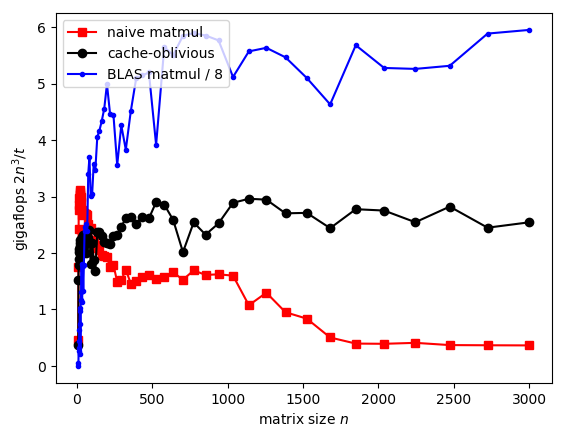

PyObject <matplotlib.legend.Legend object at 0x12c8d02e8>

In [18]:
plot(N, 2N.^3 ./ t * 1e-9, "rs-")
plot(N, 2N.^3 ./ tco * 1e-9, "ko-")
plot(N, 2N.^3 ./ t0 * 1e-9 / 8, "b.-")
ylabel(L"gigaflops $2n^3/t$")
xlabel(L"matrix size $n$")
legend(["naive matmul", "cache-oblivious", "BLAS matmul / 8"], loc="upper left")

## Matrix addition

Matrix addition is an interesting case because it has no data re-use, so there is no possible temporal locality, but depending on *what order* you use for the loops and *how matrices are stored* in memory, you may or may not get **spatial locality** that takes advantage of **cache lines**.

Here let's implement matrix addition in two different ways.  As above, we'll use a pre-allocated output array so that our benchmark does not include the time for memory allocation:

In [19]:
function matadd1!(C, A, B)
    size(C) == size(A) == size(B) || throw(DimensionMismatchmatch())
    m,n = size(A)
    for i = 1:m
        @simd for j = 1:n
            @inbounds C[i,j] = A[i,j] + B[i,j]
        end
    end
    return C
end
matadd1(A, B) = matadd1!(similar(A, promote_type(eltype(A), eltype(B))), A, B)

function matadd2!(C, A, B)
    size(C) == size(A) == size(B) || throw(DimensionMismatch())
    m,n = size(A)
    for j = 1:n
        @simd for i = 1:m
            @inbounds C[i,j] = A[i,j] + B[i,j]
        end
    end
    return C
end
matadd2(A, B) = matadd2!(similar(A, promote_type(eltype(A), eltype(B))), A, B)

A = rand(5,6)
B = rand(5,6)
A + B ≈ matadd1(A,B) ≈ matadd2(A,B)

true

In [20]:
Na = round.(Int, logspace(1, log10(3000), 60))  # 60 sizes from 10 to 3000
# alternatively, use N = 10:1000 to see some interesting patterns due to cache associativity etc.
t1 = Float64[]
t2 = Float64[]
for n in Na
    A = zeros(n,n)
    B = zeros(n,n)
    # preallocate output C so that allocation is not included in timing
    C = zeros(n,n)
    matadd1!(C,A,B) # add once just to make sure we are in cache if A and B are small
    push!(t1, @elapsed matadd1!(C,A,B))
    push!(t2, @elapsed matadd2!(C,A,B))
    println("finished n = $n: ratio t1/t2 of ", t1[end]/t2[end])
end

finished n = 10: ratio t1/t2 of 0.12873563218390807
finished n = 11: ratio t1/t2 of 0.7291066282420748
finished n = 12: ratio t1/t2 of 0.7927631578947368
finished n = 13: ratio t1/t2 of 0.7280701754385965
finished n = 15: ratio t1/t2 of 0.82010582010582
finished n = 16: ratio t1/t2 of 1.088815789473684
finished n = 18: ratio t1/t2 of 0.9535452322738386
finished n = 20: ratio t1/t2 of 1.2911764705882354
finished n = 22: ratio t1/t2 of 0.9859719438877755
finished n = 24: ratio t1/t2 of 1.2331838565022422
finished n = 26: ratio t1/t2 of 1.1630036630036629
finished n = 29: ratio t1/t2 of 1.29701230228471
finished n = 32: ratio t1/t2 of 1.601317957166392
finished n = 35: ratio t1/t2 of 1.1664766248574685
finished n = 39: ratio t1/t2 of 1.5599999999999998
finished n = 43: ratio t1/t2 of 2.246406570841889
finished n = 47: ratio t1/t2 of 1.9421487603305783
finished n = 52: ratio t1/t2 of 2.857379767827529
finished n = 57: ratio t1/t2 of 2.660377358490566
finished n = 63: ratio t1/t2 of 2.30630

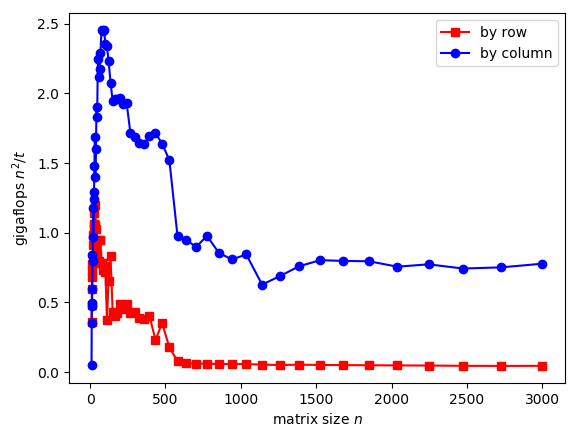

PyObject <matplotlib.legend.Legend object at 0x1248d0eb8>

In [21]:
plot(Na, Na.^2 ./ t1 * 1e-9, "rs-")
plot(Na, Na.^2 ./ t2 * 1e-9, "bo-")
xlabel(L"matrix size $n$")
ylabel(L"gigaflops $n^2/t$")
legend(["by row", "by column"])

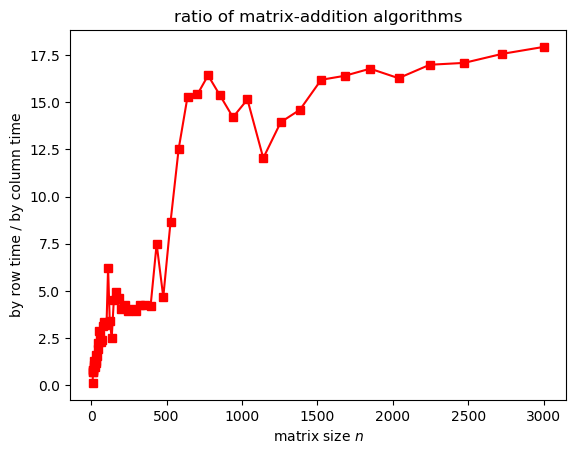

PyObject Text(0.5,1,'ratio of matrix-addition algorithms')

In [22]:
plot(Na, t1 ./ t2, "rs-")
xlabel(L"matrix size $n$")
ylabel("by row time / by column time")
title("ratio of matrix-addition algorithms")

We can see that addition is about ***20 times slower*** if we add by rows rather than by columns.

The reason for this is that **Julia stores matrices with consecutive columns**, which is known as **column-major storage** format.